In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jinja2
from dataprep.eda import create_report, plot, plot_correlation, plot_missing , plot_diff
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score
import plotly.express as px

from lightgbm import LGBMClassifier, log_evaluation
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [241]:
df = pd.read_csv('train.csv')
og = pd.read_csv('original.csv')
df.shape, og.shape

((414, 8), (79, 7))

In [242]:
df.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [243]:
df.isnull().values.any()

False

In [244]:
df.drop('id',axis=1, inplace=True)

In [245]:
# df = pd.concat([df,og],axis=0)
# df.shape

In [246]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


In [247]:
# new feats
def new_feats(feat):
    feat_copy = feat.copy()
    feat_copy['Urine_Dilution'] = feat_copy['gravity'] / feat_copy['ph']
    # feat_copy['AcidBase'] = feat_copy['ph'].apply(lambda x: 1 if x < 5 else 0)
    feat_copy['UreaAdjusted'] = feat_copy['urea'] / feat_copy['gravity']
    # feat_copy["ion_product"] = feat_copy["calc"] * feat_copy["urea"]
    # feat_copy["calcium_to_urea_ratio"] = feat_copy["calc"] / feat_copy["urea"]
    # feat_copy["electrolyte_balance"] = feat_copy["cond"] / (10 ** (-feat_copy["ph"]))
    # feat_copy["osmolality_to_sg_ratio"] = feat_copy["osmo"] / feat_copy["gravity"]
    # feat_copy['osmo_density'] = feat_copy['osmo'] * feat_copy['gravity']
    
    # # ******************************************************************
    
    # # Calculate ammonium concentration (assuming ammonium is not directly measured)
    # feat_copy['ammonium_concentration'] = (feat_copy['gravity'] - 1.010) * (140 - (2 * feat_copy["ph"])) * 1.2
    # # Calculate phosphate concentration (assuming phosphate is not directly measured)
    # feat_copy['phosphate_concentration'] = (feat_copy['gravity'] - 1.010) * (32 - (0.06 * feat_copy["ph"]))

    # # *****************************************************************
    
    # feat_copy["gravity/ph"] = feat_copy["gravity"] / feat_copy["ph"]
    # feat_copy["osmo/cond"] = feat_copy["osmo"] / feat_copy["cond"]
    # feat_copy["gravity*ph"] = feat_copy["gravity"] * feat_copy["ph"]
    # feat_copy["osmo*urea"] = feat_copy["osmo"] * feat_copy["urea"]
    # feat_copy["cond_urea_ph"] = feat_copy["cond"] * feat_copy["urea"] / feat_copy["ph"]
    # feat_copy["ph*osmo"] = feat_copy["ph"] * feat_copy["osmo"]
    # feat_copy["cond*calc"] = feat_copy["cond"] * feat_copy["calc"]
    # feat_copy["gravity/calc"] = feat_copy["gravity"] / feat_copy["calc"]
    return feat_copy

df_feats = new_feats(df)
df.shape, df_feats.shape

((414, 7), (414, 9))

In [248]:
features = [f for f in df_feats.columns if f!= 'target']
features

['gravity',
 'ph',
 'osmo',
 'cond',
 'urea',
 'calc',
 'Urine_Dilution',
 'UreaAdjusted']

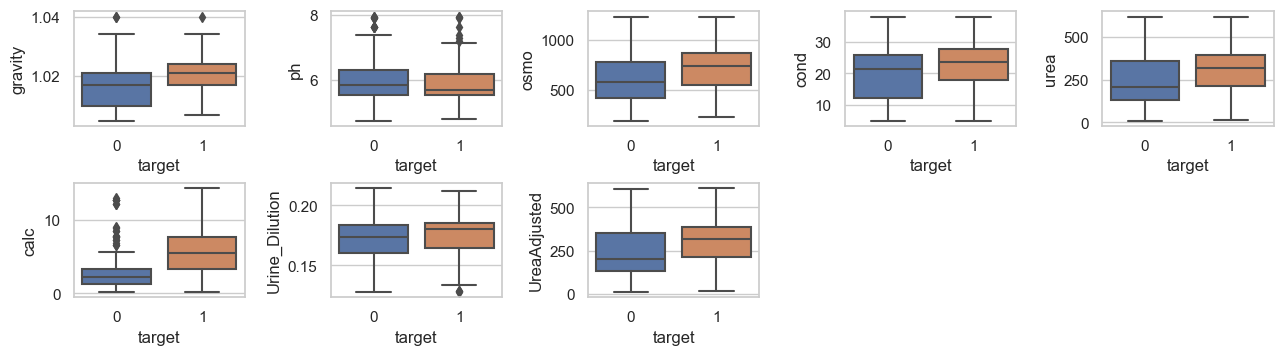

In [249]:
# Set the figure size
plt.figure(figsize=(15, 10))
sns.set_theme(style="whitegrid")
# Create categorical features subplots
for i, feature in enumerate(features):
    ax = plt.subplot(5, 5, i+1)
    sns.boxplot(x="target", y=feature , data=df_feats, ax=ax)
    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=.5, wspace=0.5)

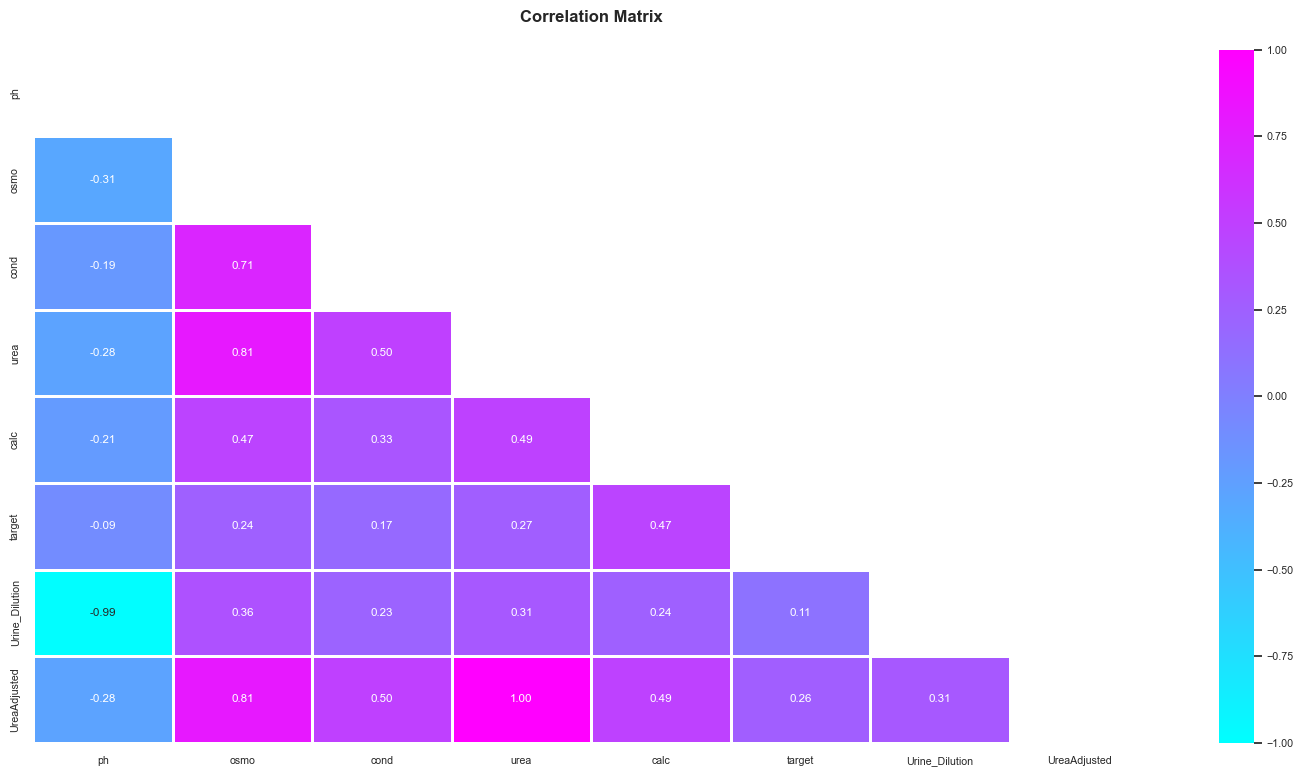

In [250]:
corr = df_feats.iloc[:,1:].corr()

# create mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create heatmap
plt.figure(figsize=(18, 9))
# set theme to change overall style
sns.set_theme(style="white", font_scale=0.7)
sns.heatmap(corr, cmap="cool", linewidths=2, mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation Matrix", fontsize=12, weight = 'bold', pad=20)
plt.show()

ph is not outlier!!

Modelling

In [251]:
X = df_feats.drop('target',axis=1)
y = df_feats.target

X.shape, y.shape

((414, 8), (414,))

In [252]:
scaler = StandardScaler()
cols = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=cols)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,3.259658e-14,1.00121,-1.933988,-0.884026,0.015941,0.615920,3.315823
ph,414.0,-1.244308e-16,1.00121,-1.863584,-0.663242,-0.335876,0.505922,3.093672
osmo,414.0,2.102451e-16,1.00121,-1.981911,-0.837465,0.119262,0.804009,2.493480
cond,414.0,1.566112e-16,1.00121,-2.176745,-0.791125,0.101534,0.820990,2.206609
urea,414.0,1.287215e-16,1.00121,-1.971399,-0.797322,-0.012159,0.780342,2.504767
calc,414.0,-6.865147e-17,1.00121,-1.227424,-0.829136,-0.306383,0.782687,3.181752
Urine_Dilution,414.0,-1.201401e-16,1.00121,-2.540957,-0.593875,0.264887,0.670762,2.351968
UreaAdjusted,414.0,-1.544658e-16,1.00121,-1.985561,-0.801613,-0.015529,0.774589,2.554023


In [253]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, stratify=y, random_state=123,test_size=0.2)
X_train.shape, X_test.shape

((331, 8), (83, 8))

In [254]:
smote = SMOTE()
X_train_smote , y_train_smote = smote.fit_resample(X_train,y_train)

In [255]:
clf = RandomForestClassifier(random_state=12,class_weight='balanced')
clf.fit(X_train,y_train)

y_pred = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'clf score: {clf.score(X_test,y_test)}, AUC: {auc}')

clf score: 0.7710843373493976, AUC: 0.8507638072855463


In [256]:
# get feature importances
importances = clf.feature_importances_

# create feature importance dataframe
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})

# sort by importance descending
feat_imp = feat_imp.sort_values('importance', ascending=False)

# create bar chart with color gradient
fig = px.bar(feat_imp, x='feature', y='importance', color='importance', color_continuous_scale='Blues')

fig.show()

In [257]:
log = LogisticRegression(random_state=12)
log.fit(X_train_smote,y_train_smote)

y_pred = log.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'log score: {log.score(X_test,y_test)}, AUC: {auc}')

log score: 0.8192771084337349, AUC: 0.8231492361927145


In [258]:
lgb = LGBMClassifier(random_state=12, class_weight='balanced',objective='binary')
lgb.fit(X_train,y_train, eval_set=(X_test,y_test),callbacks=[log_evaluation(100)])
y_pred = lgb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'lgb score: {lgb.score(X_test,y_test)}, AUC: {auc}')

[100]	valid_0's binary_logloss: 0.531061
lgb score: 0.8072289156626506, AUC: 0.8507638072855465


In [261]:
xgb = XGBClassifier(random_state=12, eval_metric='auc')
xgb.fit(X_train,y_train)
y_pred = xgb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'xgb score: {xgb.score(X_test,y_test)}, AUC: {auc}')

xgb score: 0.7590361445783133, AUC: 0.8513513513513513


In [262]:
cat = CatBoostClassifier(random_state=12, eval_metric='AUC',early_stopping_rounds=100,verbose=False, use_best_model=True)
cat.fit(X_train_smote,y_train_smote, eval_set=(X_test,y_test))
y_pred = cat.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'cat score: {cat.score(X_test,y_test)}, AUC: {auc}')

cat score: 0.7831325301204819, AUC: 0.8513513513513513
